In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Thu Jan 25 03:59:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    45W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.9999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings
hp.nonlinear = 0

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.755126953125
prior.nonlinear 0.628173828125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_nonlinear/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

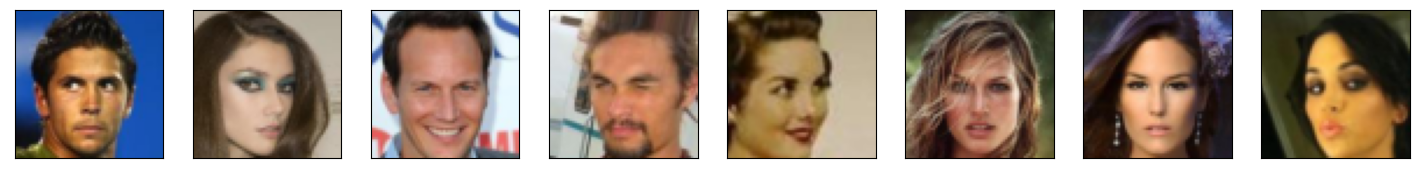

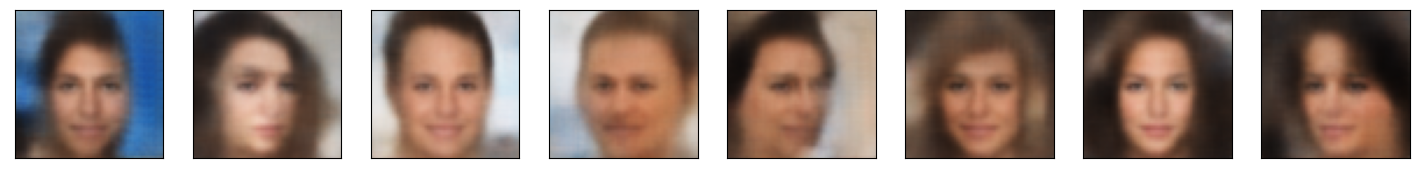

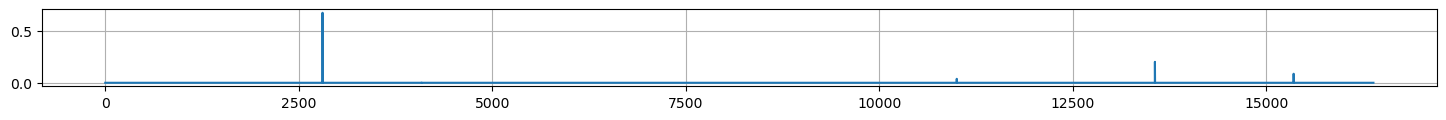

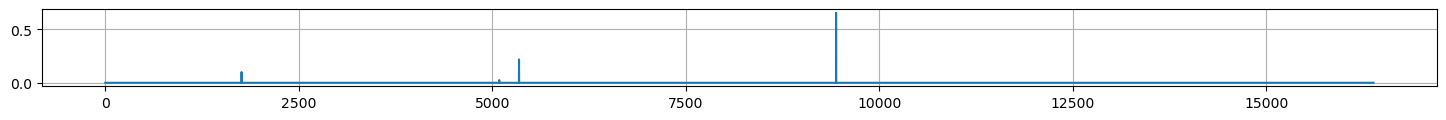

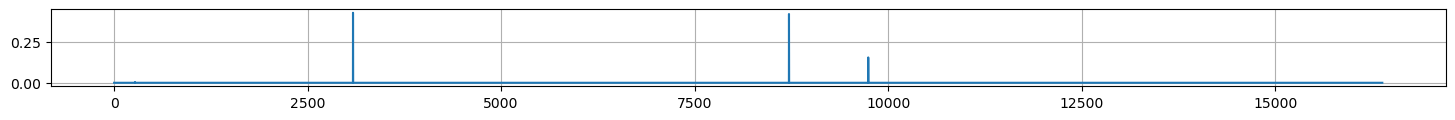

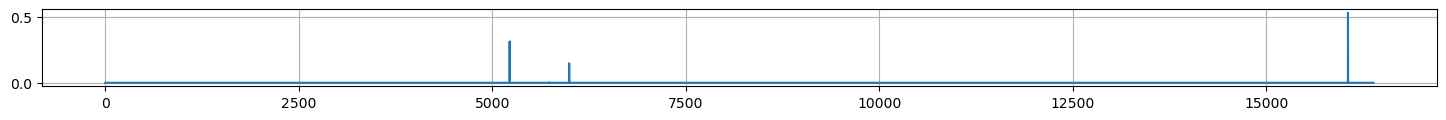

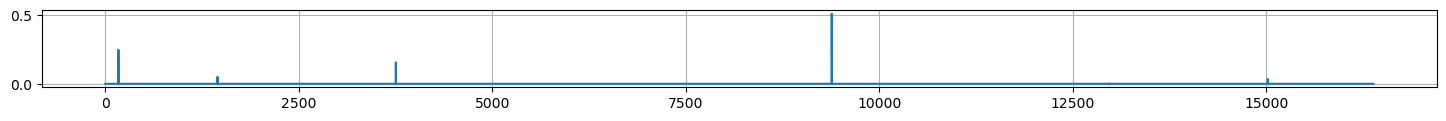

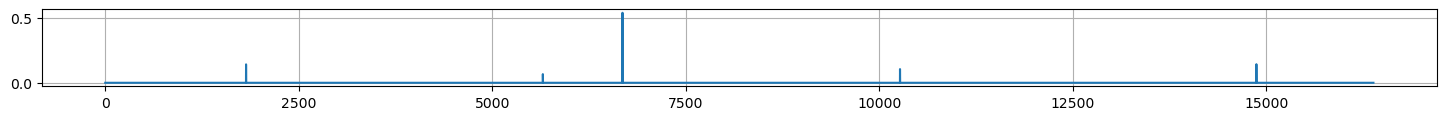

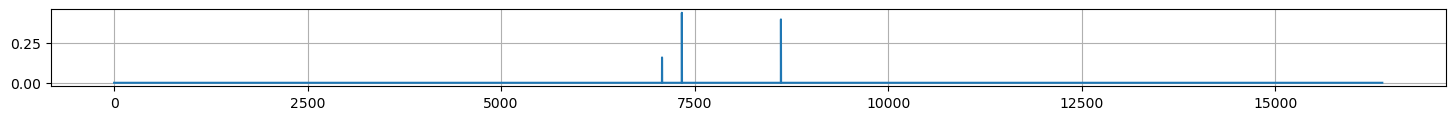

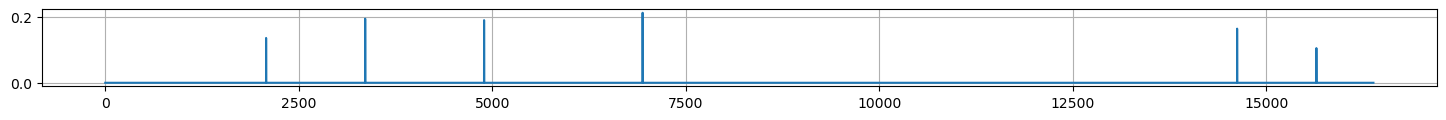

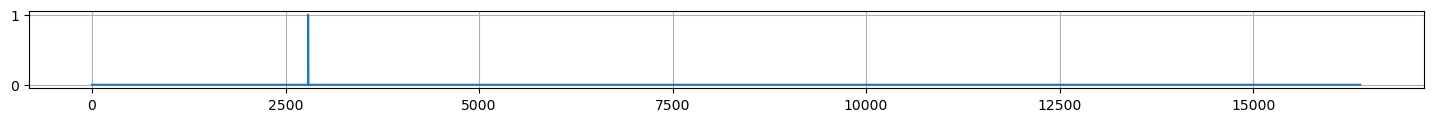

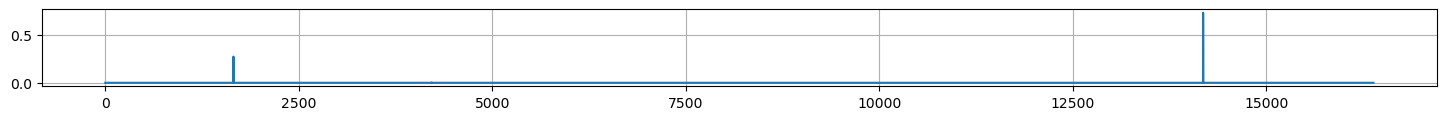

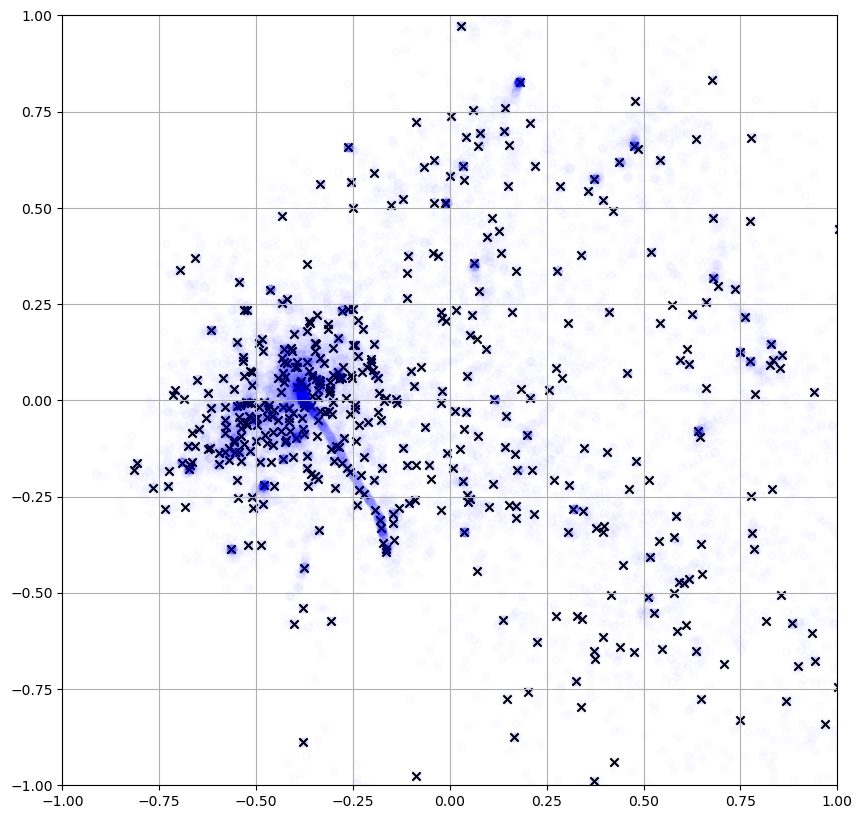

235001
lse_loss -477.85113525390625
commit_loss 0.0011906211730092764
recon_loss 0.012720206752419472
235002
lse_loss -477.231201171875
commit_loss 0.0012118993327021599
recon_loss 0.012952348217368126
235003
lse_loss -415.0191345214844
commit_loss 0.0012456589611247182
recon_loss 0.013411923311650753
235004
lse_loss -467.26947021484375
commit_loss 0.0012329225428402424
recon_loss 0.012600988149642944
235005
lse_loss -469.41259765625
commit_loss 0.0012594626750797033
recon_loss 0.012862558476626873
235006
lse_loss -472.5998229980469
commit_loss 0.0012575869914144278
recon_loss 0.012414122931659222
235007
lse_loss -473.725341796875
commit_loss 0.0012527096550911665
recon_loss 0.012879508547484875
235008
lse_loss -475.03509521484375
commit_loss 0.001187675166875124
recon_loss 0.012590751051902771
235009
lse_loss -474.11236572265625
commit_loss 0.0012351453769952059
recon_loss 0.013237429782748222
235010
lse_loss -474.5270690917969
commit_loss 0.0012310591991990805
recon_loss 0.0124645149

lse_loss -473.6260681152344
commit_loss 0.0012801210395991802
recon_loss 0.014303198084235191
235084
lse_loss -476.4410705566406
commit_loss 0.0011829014401882887
recon_loss 0.01288061123341322
235085
lse_loss -476.31365966796875
commit_loss 0.0011789724230766296
recon_loss 0.01293019950389862
235086
lse_loss -476.03167724609375
commit_loss 0.0012023639865219593
recon_loss 0.01365505438297987
235087
lse_loss -476.7469177246094
commit_loss 0.0012308850418776274
recon_loss 0.013134237378835678
235088
lse_loss -479.8282470703125
commit_loss 0.001246544299647212
recon_loss 0.012546505779027939
235089
lse_loss -481.1647644042969
commit_loss 0.0011876632925122976
recon_loss 0.01373378001153469
235090
lse_loss -479.7841796875
commit_loss 0.0012993389973416924
recon_loss 0.01258213073015213
235091
lse_loss -478.4265441894531
commit_loss 0.0012152856215834618
recon_loss 0.01352624874562025
235092
lse_loss -479.2554016113281
commit_loss 0.0012179338373243809
recon_loss 0.013189583085477352
23509

235166
lse_loss -475.968994140625
commit_loss 0.0011771594872698188
recon_loss 0.012974238023161888
235167
lse_loss -475.13006591796875
commit_loss 0.0011958132963627577
recon_loss 0.013326774351298809
235168
lse_loss -472.62933349609375
commit_loss 0.0011705608339980245
recon_loss 0.012296023778617382
235169
lse_loss -474.072021484375
commit_loss 0.0012382783461362123
recon_loss 0.013937590643763542
235170
lse_loss -474.13470458984375
commit_loss 0.0012562801130115986
recon_loss 0.013169600628316402
235171
lse_loss -475.650146484375
commit_loss 0.0011749437544494867
recon_loss 0.013291675597429276
235172
lse_loss -474.69732666015625
commit_loss 0.001241770340129733
recon_loss 0.012726406566798687
235173
lse_loss -476.00067138671875
commit_loss 0.0011738725006580353
recon_loss 0.012964487075805664
235174
lse_loss -446.2249450683594
commit_loss 0.001245576422661543
recon_loss 0.014796587638556957
235175
lse_loss -475.8421630859375
commit_loss 0.0011189408833160996
recon_loss 0.012682447

lse_loss -474.94158935546875
commit_loss 0.0012468758504837751
recon_loss 0.013187944889068604
235250
lse_loss -475.40411376953125
commit_loss 0.0012661380460485816
recon_loss 0.01297473069280386
235251
lse_loss -473.8320617675781
commit_loss 0.0011874318588525057
recon_loss 0.012442725710570812
235252
lse_loss -473.58074951171875
commit_loss 0.00126392871607095
recon_loss 0.014818858355283737
235253
lse_loss -469.046142578125
commit_loss 0.0013093084562569857
recon_loss 0.015150810591876507
235254
lse_loss -469.8227233886719
commit_loss 0.0012305299751460552
recon_loss 0.012708108872175217
235255
lse_loss -476.38299560546875
commit_loss 0.0012220280477777123
recon_loss 0.013010282069444656
235256
lse_loss -477.2474670410156
commit_loss 0.001241462305188179
recon_loss 0.01388229988515377
235257
lse_loss -474.49285888671875
commit_loss 0.001228791894391179
recon_loss 0.013436153531074524
235258
lse_loss -472.4645080566406
commit_loss 0.0012945829657837749
recon_loss 0.013696852140128613

lse_loss -455.94189453125
commit_loss 0.0012713391333818436
recon_loss 0.01330033503472805
235332
lse_loss -464.4638977050781
commit_loss 0.0013172361068427563
recon_loss 0.013230709359049797
235333
lse_loss -467.7731018066406
commit_loss 0.0012833077926188707
recon_loss 0.01285366527736187
235334
lse_loss -466.8562316894531
commit_loss 0.0013163505354896188
recon_loss 0.01257022749632597
235335
lse_loss -462.5166015625
commit_loss 0.0013564955443143845
recon_loss 0.01476012822240591
235336
lse_loss -463.42291259765625
commit_loss 0.0013205636059865355
recon_loss 0.014153434894979
235337
lse_loss -469.3697204589844
commit_loss 0.0012740639504045248
recon_loss 0.015546492300927639
235338
lse_loss -470.1697082519531
commit_loss 0.0013457167660817504
recon_loss 0.013941465876996517
235339
lse_loss -470.2545471191406
commit_loss 0.0012249537976458669
recon_loss 0.014313585124909878
235340
lse_loss -465.9283447265625
commit_loss 0.001349140889942646
recon_loss 0.014541517943143845
235341
ls

lse_loss -471.20361328125
commit_loss 0.0011923287529498339
recon_loss 0.012310336343944073
235414
lse_loss -450.7336730957031
commit_loss 0.0011585111496970057
recon_loss 0.012935361824929714
235415
lse_loss -468.8844299316406
commit_loss 0.0011394229950383306
recon_loss 0.012867696583271027
235416
lse_loss -470.679443359375
commit_loss 0.0013099913485348225
recon_loss 0.014433967880904675
235417
lse_loss -471.84033203125
commit_loss 0.001299848547205329
recon_loss 0.012282351963222027
235418


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.show() 